In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage import feature as ft
from sklearn.pipeline import Pipeline

In [12]:
#데이터 로드
train = pd.read_csv('fashion-mnist_train.csv') 
test = pd.read_csv('fashion-mnist_test.csv')
private = pd.read_csv('private_data.csv') # private data : leader board


In [13]:
# Min-Max 정규화 객체 생성
scaler = MinMaxScaler(feature_range=(-1, 1))

# train 데이터 정규화
train_val = scaler.fit_transform(train.drop(['label'], axis=1).astype('float32'))

# test 데이터 정규화
test_val = scaler.transform(test.drop(['label'], axis=1).astype('float32'))

# private 데이터 정규화
private_val = scaler.transform(private.astype('float32'))

# train_val = train.drop(['label'], axis=1).astype('float32') / 900.0
train_label = train['label']
# test_val = test.drop(['label'], axis=1).astype('float32') / 900.0
test_label = test['label']
# private_val = private.astype('float32') / 900.0








In [14]:
# 데이터 증강을 위한 함수
def augment_data(dataset, labels, augment_size=5000):
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    augmented_data = []
    augmented_labels = []

    for X, y in datagen.flow(dataset.reshape(-1, 28, 28, 1), labels, batch_size=augment_size, shuffle=False):
        augmented_data.extend(X.reshape(-1, 784))
        augmented_labels.extend(y)
        if len(augmented_data) >= augment_size:
            break

    return np.array(augmented_data), np.array(augmented_labels)

# 데이터 증강 적용
augmented_train_val, augmented_train_label = augment_data(train_val, train_label, augment_size=5000)

# 증강된 데이터와 원본 데이터 결합
train_val_combined = np.concatenate((train_val, augmented_train_val), axis=0)
train_label_combined = np.concatenate((train_label, augmented_train_label), axis=0)


In [16]:
train_val_1 = train_val_combined.reshape((-1, 28, 28))
test_val = test_val.reshape((-1, 28, 28))
private_val = private_val.reshape((-1, 28, 28))

In [17]:
def HOG_val(val):
    features = ft.hog(val, orientations=9, pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2), block_norm="L2")
    return features

In [19]:
train_HOG_val = []
for index, val in enumerate(train_val_1):
    print('\rHOG: ' + str(round((index+1)/len(train_val_1)*100, 1)) + '%', end='')
    train_HOG_val.append(HOG_val(val))
print('')

test_HOG_val = []
for index, val in enumerate(test_val):
    print('\rHOG: ' + str(round((index+1)/len(test_val)*100, 1)) + '%', end='')
    test_HOG_val.append(HOG_val(val))
print('')

private_HOG_val = []
for index, val in enumerate(private_val):
    print('\rHOG: ' + str(round((index+1)/len(private_val)*100, 1)) + '%', end='')
    private_HOG_val.append(HOG_val(val))
print('')



HOG: 100.0%
HOG: 100.0%
HOG: 100.0%


In [20]:
pca = PCA(n_components=784) # n_components -> 특징벡터 개수 설정 : 변경가능
train_val_pca =pca.fit_transform(train_HOG_val)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95) +1
print(d)

359


In [21]:
# Dimensionality Reduction using PCA : 차원축소
pca = PCA(n_components=d, random_state=42) # n_components -> 특징벡터 개수 설정 : 변경가능
train_val_pca =pca.fit_transform(train_HOG_val)
test_val_pca = pca.transform(test_HOG_val)
private_val_pca = pca.transform(private_HOG_val)
print("{} , {}".format(train_val_pca.shape, test_val_pca.shape))

(65000, 359) , (10000, 359)


In [22]:
# Optuna를 사용한 하이퍼파라미터 최적화
def objective(trial):
    # 하이퍼파라미터 범위 지정
    c = trial.suggest_float('C', 1, 30, log=True)
    gamma = trial.suggest_float('gamma', 0.001, 1.0, log=True)
    kernel = trial.suggest_categorical('kernel', ['rbf', 'poly'])

    # SVM 모델 생성
    model = SVC(C=c, gamma=gamma, kernel=kernel)

    # 교차 검증을 사용한 모델 평가
    score = cross_val_score(model, train_val_pca, train_label_combined, n_jobs=-1 , cv=3) #n_job = -1은 모든 CPU 코어를 사용하여 작업을 병렬로 처리함. -1로 하면 제 노트북에서는 메모리 사용량 초과 되서 실행이 멈춰서 1로 바꾸니깐 잘돌아감
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) #안돌아가면 n_trial 값 줄이기

# 최적 파라미터 출력
print(study.best_params)

# 최적 파라미터로 모델 훈련
best_params = study.best_params
best_svc = SVC(**best_params)
best_svc.fit(train_val_pca, train_label_combined)

# 정확도 평가
train_pred = best_svc.predict(train_val_pca)
test_pred = best_svc.predict(test_val_pca)
print("Train Accuracy:", accuracy_score(train_label_combined, train_pred))
print("Test Accuracy:", accuracy_score(test_label, test_pred))





[I 2023-12-01 05:19:50,828] A new study created in memory with name: no-name-6a17afc1-bcb9-4725-91bd-e83026486837


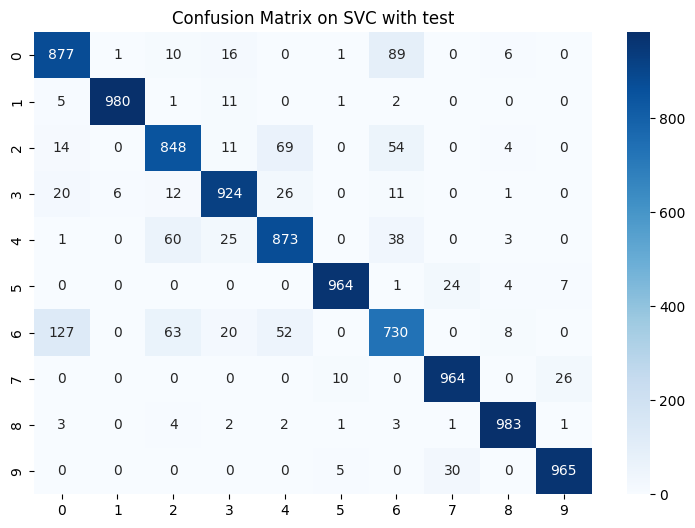

Predictions for private data saved to private_predictions.txt


In [4]:
# 혼동 행렬 시각화
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


con_matrix = confusion_matrix(test_label, test_pred)
plt.figure(figsize=(9, 6))
sns.heatmap(con_matrix, annot=True, cmap='Blues', fmt='g')
plt.title("Confusion Matrix on SVC with test")
plt.show()

# private 데이터 예측 및 결과 저장
private_pred = best_svc.predict(private_val_pca)
output_file = 'private_predictions.txt'
np.savetxt(output_file, private_pred, fmt='%d')
print(f"Predictions for private data saved to {output_file}")


In [ ]:
output_file = 'public_predictions.txt'
np.savetxt(output_file, test_pred, fmt='%d')
print(f"Predictions for private data saved to {output_file}")